In [17]:
llema_file_path = "inference_sat_math_results/llemma_math_sat_answers_2.csv"

mistral_file_path = "inference_sat_math_results/Mistral_Inference_SAT_Dataset.csv"

llama_file_path = "inference_sat_math_results/the_inference_llama3_sat_math.csv"

qwen_file_path = "inference_sat_math_results/inference_QWEN_sat_math.csv"

def extract_numbers(s):
    normalized = re.sub(r'[^\d\s]', '', s)  
    return list(map(int, re.findall(r'\d+', normalized))) 
def compare_number_lists(list1, list2):
    return set(list1).issubset(set(list2))  # list1=correct solution

In [18]:
import pandas as pd
from datasets import load_dataset, DatasetDict, Dataset
import matplotlib.pyplot as plt
import re


sat_math_dict = load_dataset("knazarali3/group2_processed_sat_math_cot")
train_dataset = sat_math_dict["train"]
test_dataset = sat_math_dict["test"]
test_dataset_df = pd.DataFrame(test_dataset)
test_dataset_df["row_index"] = test_dataset_df.index

In [19]:

def format_llema_inference_sat_math():
    df = pd.read_csv(llema_file_path, index_col=0)
    llema_test_dataset= df.merge(test_dataset_df, left_on='Question Id', right_on='id')

    llema_test_dataset['Correct Final Solution'] = llema_test_dataset['answer'].apply(extract_numbers)

    llema_test_dataset["llema_is_correct"] = llema_test_dataset.apply(
        lambda row: row["Final Solution"] in row["Correct Final Solution"], axis=1
    )

    llema_test_dataset = llema_test_dataset.rename(columns={"Final Solution": "llema_solution"})

    llema_3_results = llema_test_dataset[["Question Id", "llema_is_correct", "llema_solution"]]
    return llema_3_results


def format_mistral_inference_sat_math():
    df = pd.read_csv(mistral_file_path)
    mistral_test_dataset= df.merge(test_dataset_df, left_on='ID', right_on='id')

    mistral_test_dataset['Final Solution Numbers'] = mistral_test_dataset['answer'].apply(extract_numbers)


    mistral_test_dataset['Run_1'] = mistral_test_dataset['Run_1'].astype(str)

    mistral_test_dataset['Mistral Model Solution Numbers'] = mistral_test_dataset['Run_1'].apply(extract_numbers)

    mistral_test_dataset['mistral_is_correct'] = [
        compare_number_lists(a, b) for a, b in zip(mistral_test_dataset['Final Solution Numbers'], mistral_test_dataset['Mistral Model Solution Numbers'])
    ]

    mistral_test_dataset = mistral_test_dataset.rename(columns={"ID": "Question Id"})

    mistral_results = mistral_test_dataset[["Question Id", "mistral_is_correct", "Mistral Model Solution Numbers"]]
    return mistral_results    

def format_llama_inference_sat_math():
    df = pd.read_csv(llama_file_path)
    llama_test_dataset= df.merge(test_dataset_df, left_on='ID', right_on='id')

    llama_test_dataset['Final Solution Numbers'] = llama_test_dataset['answer'].apply(extract_numbers)

    llama_test_dataset['Run_1'] = llama_test_dataset['Run_1'].astype(str)

    llama_test_dataset['Llama Model Solution Numbers'] = llama_test_dataset['Run_1'].apply(extract_numbers)

    llama_test_dataset['llama_is_correct'] = [
        compare_number_lists(a, b) for a, b in zip(llama_test_dataset['Final Solution Numbers'], llama_test_dataset['Llama Model Solution Numbers'])
    ]

    llama_test_dataset = llama_test_dataset.rename(columns={"ID": "Question Id"})

    llama_results = llama_test_dataset[["Question Id", "llama_is_correct", "Llama Model Solution Numbers"]]
    return llama_results

def format_qwen_inference_sat_math():
    df = pd.read_csv(qwen_file_path)
    qwen_test_dataset= df.merge(test_dataset_df, left_on='row_index', right_on='row_index')


    qwen_test_dataset['Final Solution Numbers'] = qwen_test_dataset['answer'].apply(extract_numbers)

    qwen_test_dataset['Run_1'] = qwen_test_dataset['Run_1'].astype(str)

    qwen_test_dataset['Qwen Model Solution Numbers'] = qwen_test_dataset['Run_1'].apply(extract_numbers)

    qwen_test_dataset['qwen_is_correct'] = [
        compare_number_lists(a, b) for a, b in zip(qwen_test_dataset['Final Solution Numbers'], qwen_test_dataset['Qwen Model Solution Numbers'])
    ]

    qwen_test_dataset = qwen_test_dataset.rename(columns={"id": "Question Id"})

    qwen_results = qwen_test_dataset[["Question Id", "qwen_is_correct", "Qwen Model Solution Numbers"]]

    return qwen_results

In [20]:
llama_results = format_llama_inference_sat_math()
llema_results = format_llema_inference_sat_math()
qwen_results = format_qwen_inference_sat_math()
mistral_results = format_mistral_inference_sat_math()

# Check where all the answers correct column is True
# i.e. all models got the answer correct
all_results = ((llama_results.merge(llema_results)).merge(qwen_results)).merge(mistral_results)

all_results["all_incorrect"] = (all_results["llama_is_correct"] == False) & (all_results["llema_is_correct"] == False) & (all_results["qwen_is_correct"] == False) & (all_results["mistral_is_correct"]==False)

all_results["all_incorrect"].value_counts()

all_incorrect
False    4769
True     1425
Name: count, dtype: int64

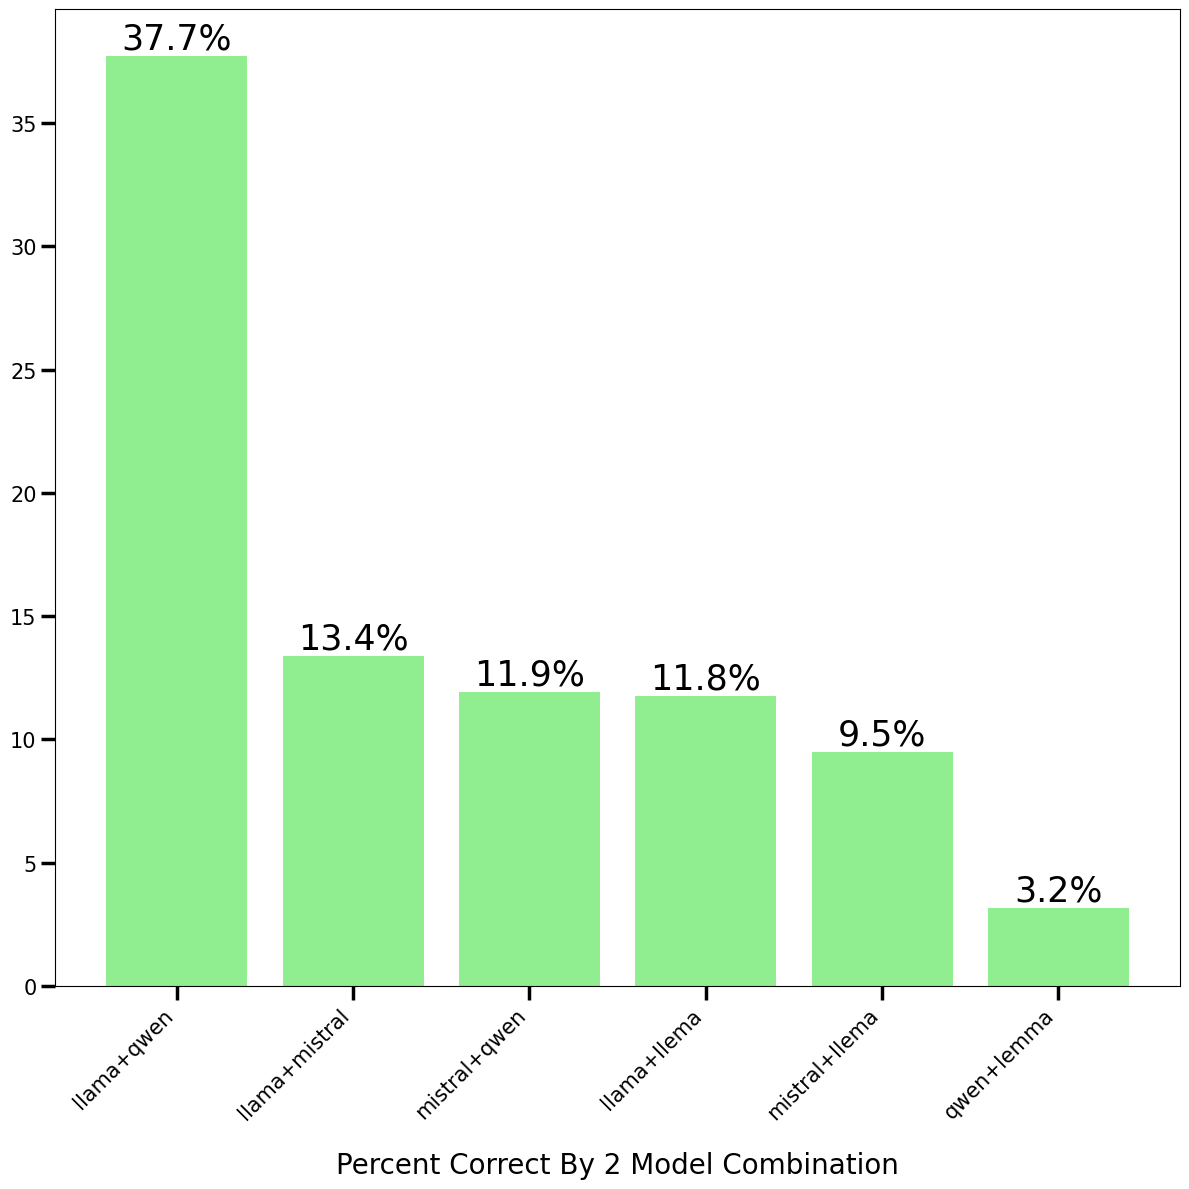

In [21]:
'''
Llama + Mistral
Llama + Qwen
Llama + Llema
Mistral + Qwen
Mistral + Llema
Qwen + Llema
'''
llamaplusmistral = all_results[(all_results["llama_is_correct"] == True) & (all_results["mistral_is_correct"] == True)]


llamaplusqwen = all_results[(all_results["llama_is_correct"] == True) & (all_results["qwen_is_correct"] == True)]


llamaplusllema = all_results[(all_results["llama_is_correct"] == True) & (all_results["llema_is_correct"] == True)]


mistralplusqwen = all_results[(all_results["mistral_is_correct"] == True) & (all_results["qwen_is_correct"] == True)]


mistralplusllema = all_results[(all_results["mistral_is_correct"] == True) & (all_results["llema_is_correct"] == True)]


qwenpluslemma = all_results[(all_results["qwen_is_correct"] == True) & (all_results["llema_is_correct"] == True)]



accuracies = pd.DataFrame(list(zip([len(llamaplusmistral), len(llamaplusqwen), len(llamaplusllema), len(mistralplusqwen), len(qwenpluslemma), len(mistralplusllema)])))
total_sum = len(all_results)
accuracies.index = ["llama+mistral", "llama+qwen", "llama+llema", "mistral+qwen", "mistral+llema", "qwen+lemma"]
accuracies.columns = ["percent"]
accuracies["percent"] = (accuracies["percent"] / total_sum)*100
accuracies = accuracies.sort_values(by=['percent'], ascending=False)

accuracies

fig, ax = plt.subplots(figsize=(12, 12))  

bars = plt.bar(accuracies.index, accuracies["percent"], color = "lightgreen")

ax.bar_label(bars, fmt="%.1f%%", label_type='edge', fontsize=25) 

ax.set_xlabel("Percent Correct By 2 Model Combination", labelpad=20)

ax.tick_params(axis='both', which='major', labelsize=15, width=2.5, length=10)


ax.set_xlabel('Percent Correct By 2 Model Combination', fontsize=20)

plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()

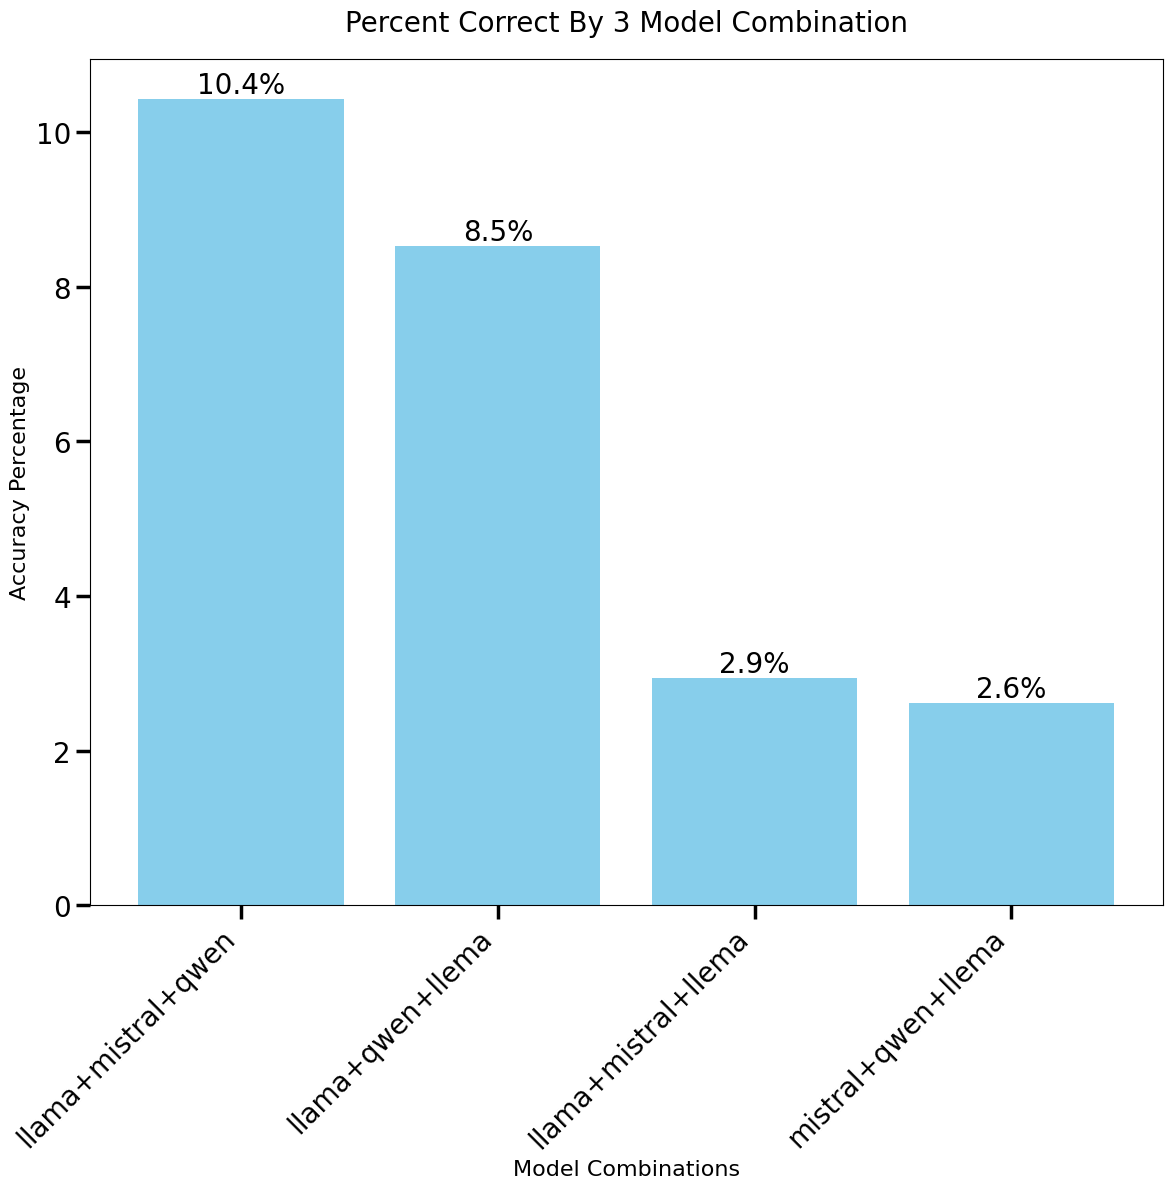

In [23]:
# Trigram combinations: 
llama_mistral_qwen = all_results[
    (all_results["llama_is_correct"] == True) & 
    (all_results["mistral_is_correct"] == True) & 
    (all_results["qwen_is_correct"] == True)
]

llama_mistral_llema = all_results[
    (all_results["llama_is_correct"] == True) & 
    (all_results["mistral_is_correct"] == True) & 
    (all_results["llema_is_correct"] == True)
]

llama_qwen_llema = all_results[
    (all_results["llama_is_correct"] == True) & 
    (all_results["qwen_is_correct"] == True) & 
    (all_results["llema_is_correct"] == True)
]

mistral_qwen_llema = all_results[
    (all_results["mistral_is_correct"] == True) & 
    (all_results["qwen_is_correct"] == True) & 
    (all_results["llema_is_correct"] == True)
]

# Calculate accuracies
accuracies_trigram = pd.DataFrame(
    list(
        zip(
            [len(llama_mistral_qwen), len(llama_mistral_llema), len(llama_qwen_llema), len(mistral_qwen_llema)],
            ["llama+mistral+qwen", "llama+mistral+llema", "llama+qwen+llema", "mistral+qwen+llema"]
        )
    ),
    columns=["correct_count", "combination"]
)

total_sum = len(all_results)
accuracies_trigram["percent"] = (accuracies_trigram["correct_count"] / total_sum) * 100
accuracies_trigram = accuracies_trigram.sort_values(by=['percent'], ascending=False)

# Plot results
fig, ax = plt.subplots(figsize=(12, 12))

bars = plt.bar(accuracies_trigram["combination"], accuracies_trigram["percent"], color="skyblue")

ax.bar_label(bars, fmt="%.1f%%", label_type='edge', fontsize=20)

ax.set_title("Percent Correct By 3 Model Combination", fontsize=20, pad=20)
ax.set_xlabel("Model Combinations", fontsize=16)
ax.set_ylabel("Accuracy Percentage", fontsize=16)

ax.tick_params(axis='both', which='major', labelsize=20, width=2.5, length=10)
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()


In [11]:
#all_models_questions_got_wrong_sat_math = all_results[all_results["all_incorrect"]==True]
#all_models_questions_got_wrong_sat_math.to_csv("all_models_questions_got_wrong_sat_math.csv")

In [13]:
all_results["all_correct"] = (all_results["llama_is_correct"] == True) & (all_results["llema_is_correct"] == True) & (all_results["qwen_is_correct"] == True) & (all_results["mistral_is_correct"]==True)

all_results["all_incorrect"] = (all_results["llama_is_correct"] == False) & (all_results["llema_is_correct"] == False) & (all_results["qwen_is_correct"] == False) & (all_results["mistral_is_correct"]==False)


Text(0.5, 0, 'Perent Correct By Each Model')

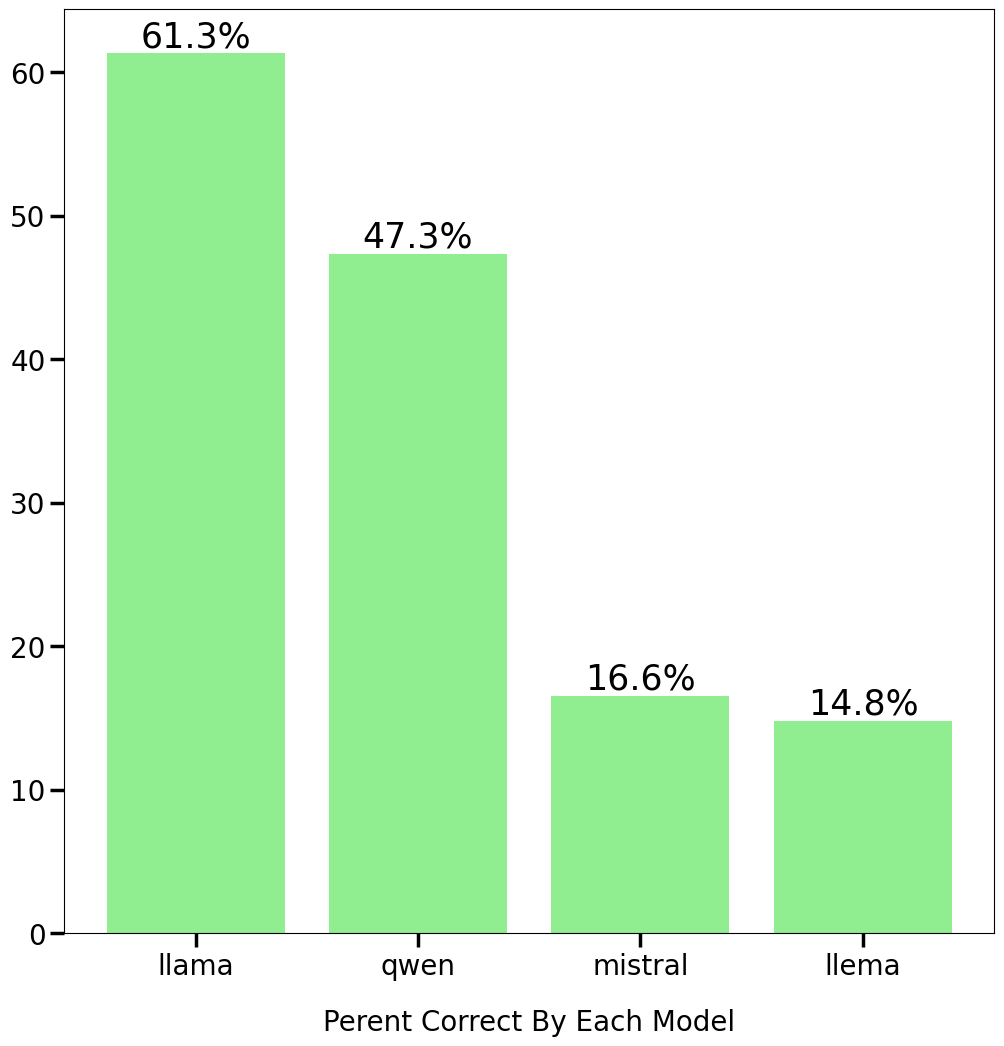

In [14]:
llama = all_results[all_results["llama_is_correct"] == True]
llema = all_results[all_results["llema_is_correct"] == True]
mistral = all_results[all_results["mistral_is_correct"] == True]
qwen = all_results[all_results["qwen_is_correct"] == True]

accuracies = pd.DataFrame(list(zip([len(llama), len(llema), len(mistral), len(mixed_qwen)])))
total_sum = len(all_results)
accuracies.index = ["llama", "llema", "mistral", "qwen"]
accuracies.columns = ["percent"]
accuracies["percent"] = (accuracies["percent"] / total_sum)*100
accuracies = accuracies.sort_values(by=['percent'], ascending=False)

accuracies

fig, ax = plt.subplots(figsize=(12, 12))  

bars = plt.bar(accuracies.index, accuracies["percent"], color = "lightgreen")

ax.bar_label(bars, fmt="%.1f%%", label_type='edge', fontsize=25) 

ax.set_xlabel("Percent Correct By Each Model", labelpad=20)

ax.tick_params(axis='both', which='major', labelsize=20, width=2.5, length=10)

ax.set_xlabel('Perent Correct By Each Model', fontsize=20)

Text(0.5, 0, 'Percent Correct Excluding all correct and all incorrect')

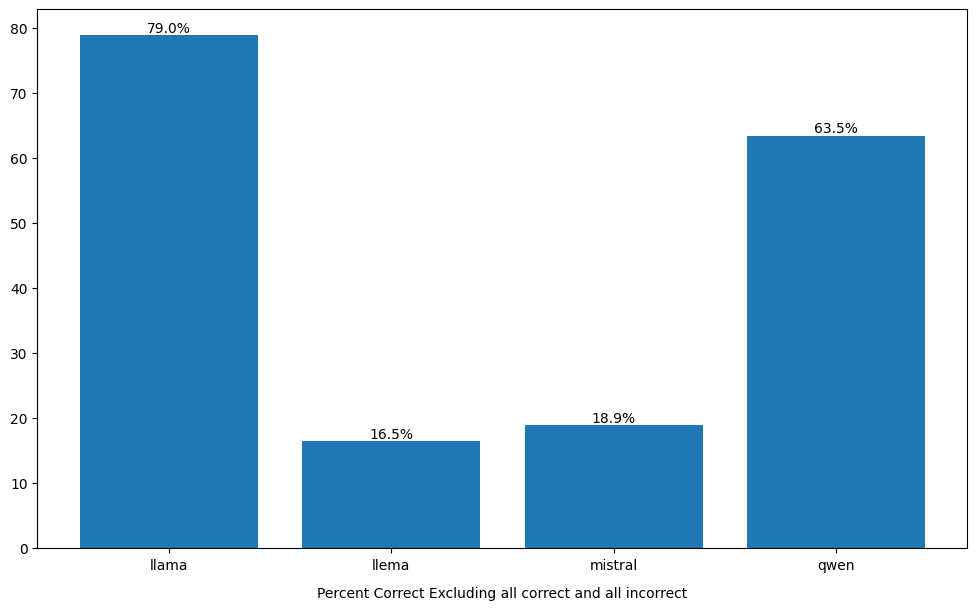

In [8]:
mixed_llama = all_results[(all_results["llama_is_correct"] == True) & (all_results["all_correct"] == False) & (all_results["all_incorrect"]==False)]
mixed_llema = all_results[(all_results["llema_is_correct"] == True) & (all_results["all_correct"] == False) & (all_results["all_incorrect"]==False)]
mixed_mistral = all_results[(all_results["mistral_is_correct"] == True) & (all_results["all_correct"] == False) & (all_results["all_incorrect"]==False)]
mixed_qwen = all_results[(all_results["qwen_is_correct"] == True) & (all_results["all_correct"] == False) & (all_results["all_incorrect"]==False)]

mixed_accuracies = pd.DataFrame(list(zip([len(mixed_llama), len(mixed_llema), len(mixed_mistral), len(mixed_qwen)])))
total_sum = len(all_results[(all_results["all_correct"] == False) & (all_results["all_incorrect"]==False)])
mixed_accuracies.index = ["llama", "llema", "mistral", "qwen"]
mixed_accuracies.columns = ["percent"]
mixed_accuracies["percent"] = (mixed_accuracies["percent"] / total_sum)*100
mixed_accuracies

fig, ax = plt.subplots(figsize=(12, 7))  

bars = plt.bar(mixed_accuracies.index, mixed_accuracies["percent"])

ax.bar_label(bars, fmt="%.1f%%", label_type='edge', fontsize=10) 

ax.set_xlabel("Percent Correct Excluding all correct and all incorrect", labelpad=10)